In [18]:
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

viridis = mpl.colormaps["viridis"]


def color_p(p):
    return viridis(p / 7)

/tmp/ipykernel_3154060/806139119.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle, p in zip(legend.legendHandles, [0, 1, 2, 3, 4, 5, 6, 7]):


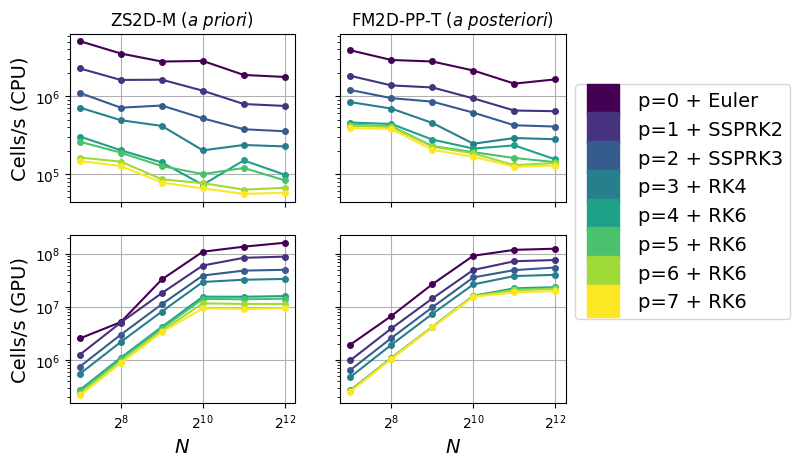

In [25]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey="row")

df = pd.read_csv("data/timing.csv")


for p, df_p in df.groupby("p"):
    for scheme, df_lim in df_p.groupby("scheme"):
        for device, df_dev in df_lim.groupby("device"):
            filtered_df = df_dev[df_dev.n >= 128]
            i = int(device == "gpu")
            j = {"ZS2D-M-Fdt": 0, "FM2D-PP-T": 1}[scheme]
            integrator_name = {
                "euler": "Euler",
                "ssprk2": "SSPRK2",
                "ssprk3": "SSPRK3",
                "rk4": "RK4",
                "rk6": "RK6",
            }[df_dev.integrator.to_list()[0]]
            axs[i, j].plot(
                filtered_df.n,
                filtered_df.n_cells_updated_per_s,
                marker="o",
                markersize=4,
                color=color_p(p),
                label=f"{p=} + {integrator_name}",
            )

# cosmetics
fontsize = 14
axs[0, 0].set_yscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xscale("log", base=2)
axs[1, 0].set_xlabel("$N$", fontsize=fontsize)
axs[1, 1].set_xlabel("$N$", fontsize=fontsize)
axs[0, 0].set_ylabel("Cells/s (CPU)", fontsize=fontsize)
axs[1, 0].set_ylabel("Cells/s (GPU)", fontsize=fontsize)
for i, j in product((0, 1), (0, 1)):
    axs[i, j].grid()
axs[0, 0].set_title("ZS2D-M ($\it{a}$ $\it{priori}$)")
axs[0, 1].set_title("FM2D-PP-T ($\it{a}$ $\it{posteriori}$)")

# legend
if True:
    legend = axs[0, 1].legend(
        loc="center left", bbox_to_anchor=(1.0, 0), fontsize=fontsize
    )
    for line in legend.get_lines():
        line.set_linestyle("none")
        line.set_marker("s")
    for handle, p in zip(legend.legendHandles, [0, 1, 2, 3, 4, 5, 6, 7]):
        if p == -1:
            handle.set_markerfacecolor("grey")
        else:
            handle.set_markerfacecolor(color_p(p))
        handle.set_markersize(1.6 * fontsize)

plt.savefig("images/timing.png", dpi=300, bbox_inches="tight")